Current Results and findings

Dataset + target situation 
* You have 99 student records with 9 original features, and after one-hot encoding it becomes 13 columns. 
* The target DepressionStatus originally had 3 classes (Sometimes/Yes/No), and you converted it to binary:
    * At Risk (1) = Yes + Sometimes = 78 (78.8%)
    * Not Depressed (0) = No = 21 (21.2%).This means dataset is imbalanced (majority class is “At Risk”).
EDA signals (what features look meaningful)
* SleepPerDayHours shows a noticeable difference between groups → likely useful predictor. 
* NumberOfFriend is highly skewed with big outliers (up to ~100) → can distort models. 
* Numeric correlations are near zero → no strong multicollinearity problem. 
Baseline model result (what it actually means)
Your baseline Logistic Regression pipeline got:
* Accuracy = 0.90
* Confusion Matrix: [[3,1],[1,15]]
    * TN=3, FP=1, FN=1, TP=15
* Class report:
    * Class 0 (Not depressed): precision/recall/F1 = 0.75
    * Class 1 (At risk): precision/recall/F1 ≈ 0.94 
Interpretation:
* The model is doing very well on the majority class (At Risk).
* It is only okay on the minority class (Not Depressed) because there are only 4 “0” samples in the test split (support=4). So the 0.90 accuracy is not a guarantee the model is truly strong—small test size + imbalance can make accuracy look high.

Decision process

Convert to binary (Yes/Sometimes vs No)

* simplified the prediction task to “at risk vs not,” which matches a screening-style ML objective.
* It also helps because the dataset is small; multi-class would be harder to learn reliably.
Use leakage-safe preprocessing (Pipeline + ColumnTransformer)

* Imputation, scaling, and encoding happen inside the pipeline, so your model never “sees” test-set statistics during training. 
Stratified split
With imbalance, stratify=y is important so both train/test have similar class proportions.

Start with a baseline model first
Logistic Regression is:
* Interpretable (coefficients)
* Quick to run and debug
* A solid reference point before trying more complex models
* 
Step 1 — Replace single train/test with Stratified 5-fold CV
Because test set is tiny (20 samples), performance can swing a lot. 
report mean + std for F1, Recall, ROC-AUC across folds (more trustworthy than one split).

Step 2 — Handle imbalance explicitly
Do at least one of these (you already planned it):
* class_weight="balanced" for Logistic Regression / Random Forest Then compare metrics, especially Recall (catching at-risk students) and F1.
Step 3 — Train 1–2 stronger models and compare fairly
Your planned comparison is appropriate:
* Logistic Regression (baseline, interpretable)
* Random Forest (handles nonlinearity + outliers better) 
    Optional: XGBoost only if you do careful CV/tuning, since n=99 is small.
Interpretability: explain “what drives predictions”
* Logistic Regression coefficients (direction + strength)
* Permutation importance (works for any model) 
* 
Address the risky feature: NumberOfFriend
Because it’s skewed/outliers, try one simple treatment and check if CV metrics improve:
* log transform (e.g., log1p) OR
* winsorize/cap extreme values OR
* RobustScaler (instead of StandardScaler)


In [13]:
%pip install seaborn
%pip install kagglehub
%pip install scikit-learn
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install xgboost


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Users/nyeinchanaung/Downloads/ML:CP Project/cp-env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Users/nyeinchanaung/Downloads/ML:CP Project/cp-env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Users/nyeinchanaung/Downloads/ML:CP Project/cp-env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Users/nyeinchanaung/Downloads/ML:CP Project/cp-env/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of p

In [14]:
#import libraries 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [15]:
#load data
Datapath ='Data/CSE_student_performances.csv'
data = pd.read_csv(Datapath)
#explore data
print(data.head())
print(data.info())
print(data.describe())

# 2) Missing values (overall + per column)
missing_per_col = data.isna().sum().sort_values(ascending=False)
print("\nMissing values per column (top 15):")
print(missing_per_col.head(15))

# 3) Basic types
print("\nDtypes:\n", data.dtypes)

# 4) Quick numeric summary
display(data.describe(include="number").T)

# 5) Quick categorical summary (top categories)
cat_cols_guess = data.select_dtypes(include=["object", "category"]).columns
for c in cat_cols_guess[:10]:  # show first 10 only
    print(f"\nColumn: {c}")
    print(data[c].value_counts(dropna=False).head(10))




   Age   Gender AcademicPerformance TakingNoteInClass DepressionStatus  \
0    23    Male             Average                No        Sometimes   
1    23    Male           Excellent         Sometimes              Yes   
2    24    Male             Average                No        Sometimes   
3    20  Female                Good               Yes        Sometimes   
4    24  Female             Average               Yes              Yes   

  FaceChallangesToCompleteAcademicTask LikePresentation  SleepPerDayHours  \
0                                  Yes              Yes                12   
1                                   No              Yes                 8   
2                            Sometimes               No                 8   
3                                  Yes               No                 5   
4                                  Yes              Yes                 5   

   NumberOfFriend LikeNewThings  
0             NaN           Yes  
1            80.0       

,count,mean,std,min,25%,50%,75%,max
Age,99.0,22.515152,1.560767,20.0,21.0,23.0,24.0,25.0
SleepPerDayHours,99.0,6.717172,1.738169,4.0,5.0,7.0,8.0,12.0
NumberOfFriend,95.0,16.189474,25.397811,0.0,3.0,6.0,15.0,100.0



Column: Gender
Gender
Male      56
Female    43
Name: count, dtype: int64

Column: AcademicPerformance
AcademicPerformance
Average          45
Good             41
Excellent         9
Below average     4
Name: count, dtype: int64

Column: TakingNoteInClass
TakingNoteInClass
Yes          61
Sometimes    26
No           12
Name: count, dtype: int64

Column: DepressionStatus
DepressionStatus
Sometimes    44
Yes          34
No           21
Name: count, dtype: int64

Column: FaceChallangesToCompleteAcademicTask
FaceChallangesToCompleteAcademicTask
Yes          37
No           31
Sometimes    31
Name: count, dtype: int64

Column: LikePresentation
LikePresentation
Yes    69
No     30
Name: count, dtype: int64

Column: LikeNewThings
LikeNewThings
Yes    89
No     10
Name: count, dtype: int64


/var/folders/_r/1mtvh9nn1ns69vtxm47ygl1c0000gn/T/ipykernel_15776/2410881801.py:21: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols_guess = data.select_dtypes(include=["object", "category"]).columns


In [16]:
#Define features and target
X = data.drop(columns=['DepressionStatus'])
y = data['DepressionStatus']

print("X shape:", X.shape)
print("y shape:", y.shape)

print("\nTarget distribution:")
print(y.value_counts())

print("Unique target values:", y.unique())
y = y.astype(str).str.strip().str.lower()


# Binary encoding
y = y.map({
    "yes": 1,
    "sometimes": 1,
    "no": 0
})

print("New target distribution:")
print(y.value_counts())

# STEP 4: Detect feature types
# =========================================

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "string"]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Shape after encoding:", X_encoded.shape)
display(X_encoded.head())

print("Final X shape:", X_encoded.shape)
print("Final y shape:", y.shape)

# Make sure no missing values
print("Missing values in X:", X_encoded.isna().sum().sum())
print("Missing values in y:", y.isna().sum())

missing_per_column = X_encoded.isna().sum()
print(missing_per_column[missing_per_column > 0])

X_encoded["NumberOfFriend"] = X_encoded["NumberOfFriend"].fillna(
    X_encoded["NumberOfFriend"].median())
print("Missing values in NumberOfFriend after imputation:",
      X_encoded["NumberOfFriend"].isna().sum())

X shape: (99, 9)
y shape: (99,)

Target distribution:
DepressionStatus
Sometimes    44
Yes          34
No           21
Name: count, dtype: int64
Unique target values: <StringArray>
['Sometimes', 'Yes', 'No']
Length: 3, dtype: str
New target distribution:
DepressionStatus
1    78
0    21
Name: count, dtype: int64
Numeric columns: ['Age ', 'SleepPerDayHours', 'NumberOfFriend']
Categorical columns: ['Gender', 'AcademicPerformance', 'TakingNoteInClass', 'FaceChallangesToCompleteAcademicTask', 'LikePresentation', 'LikeNewThings']
Shape after encoding: (99, 13)


,Age,SleepPerDayHours,NumberOfFriend,Gender_Male,AcademicPerformance_Below average,AcademicPerformance_Excellent,AcademicPerformance_Good,TakingNoteInClass_Sometimes,TakingNoteInClass_Yes,FaceChallangesToCompleteAcademicTask_Sometimes,FaceChallangesToCompleteAcademicTask_Yes,LikePresentation_Yes,LikeNewThings_Yes
0,23,12,NaN,True,False,False,False,False,False,False,True,True,True
1,23,8,80.0,True,False,True,False,True,False,False,False,True,True
2,24,8,10.0,True,False,False,False,False,False,True,False,False,True
3,20,5,15.0,False,False,False,True,False,True,False,True,False,True
4,24,5,2.0,False,False,False,False,False,True,False,True,True,True


Final X shape: (99, 13)
Final y shape: (99,)
Missing values in X: 4
Missing values in y: 0
NumberOfFriend    4
dtype: int64
Missing values in NumberOfFriend after imputation: 0


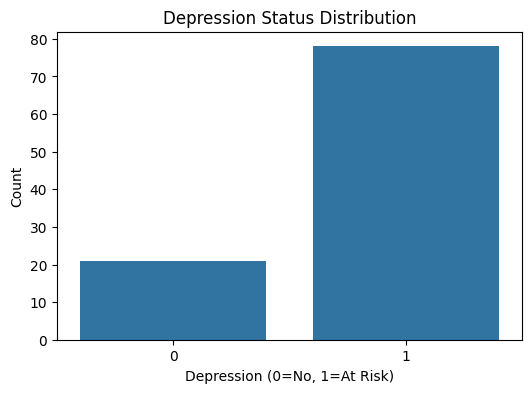

DepressionStatus
1    0.787879
0    0.212121
Name: proportion, dtype: float64


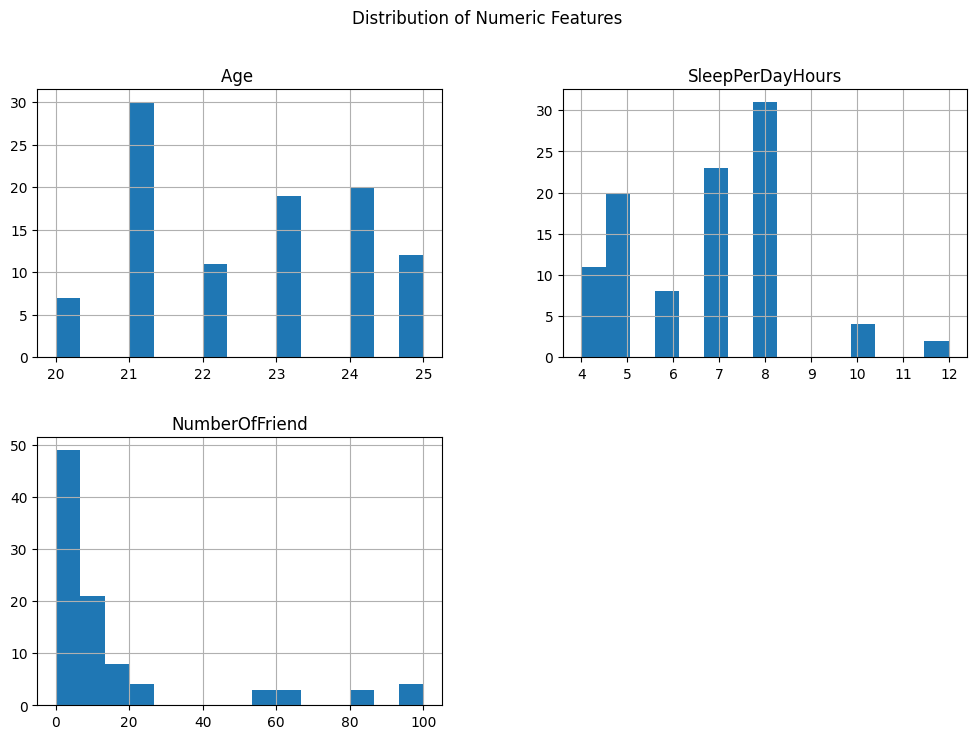

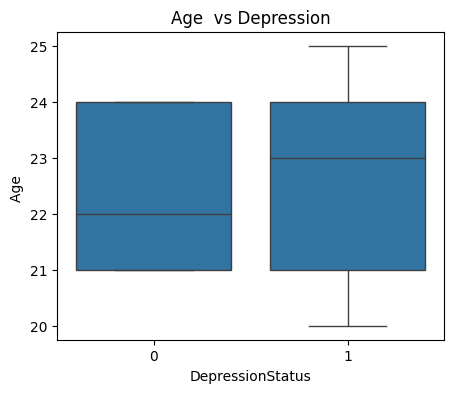

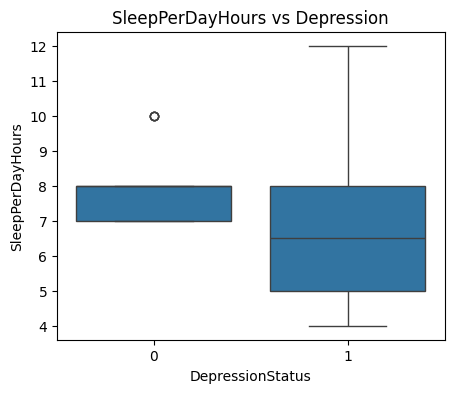

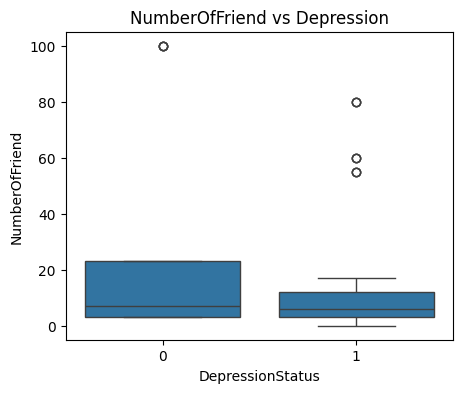

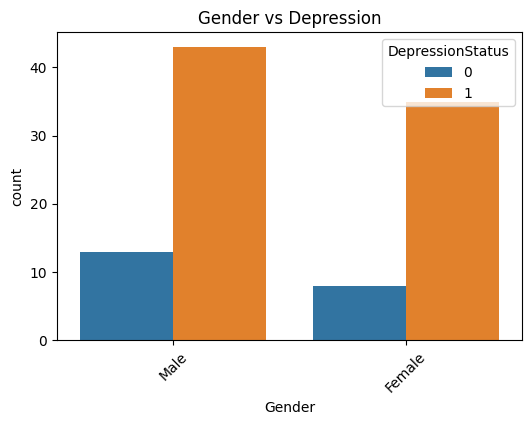

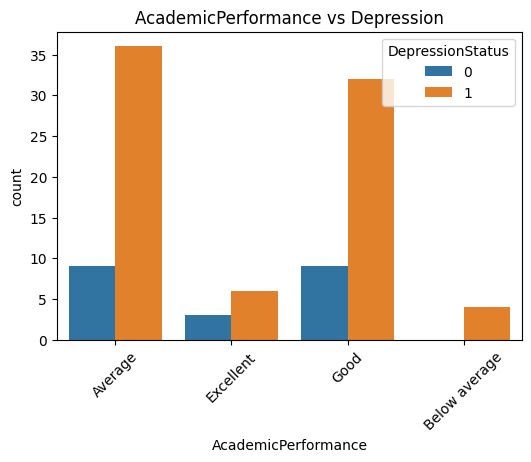

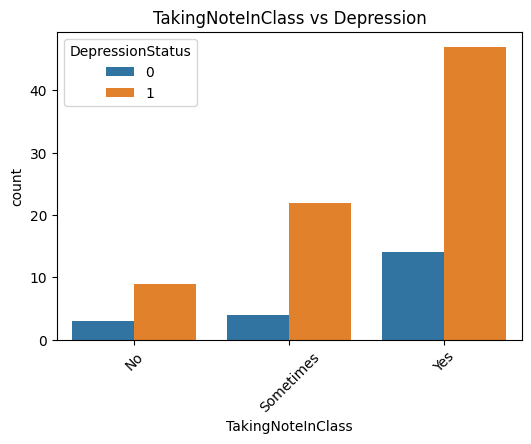

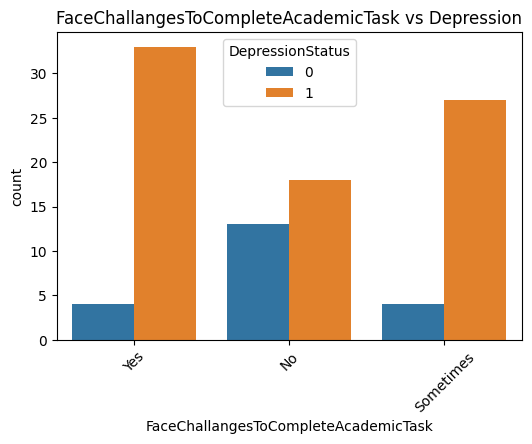

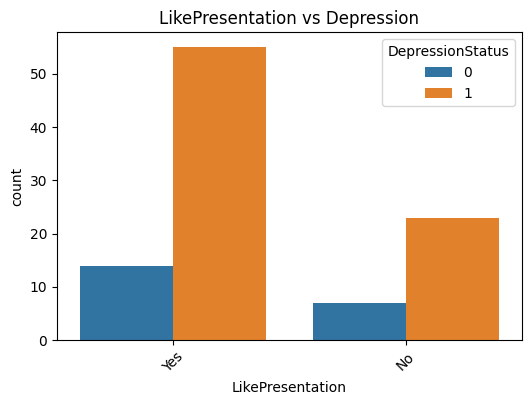

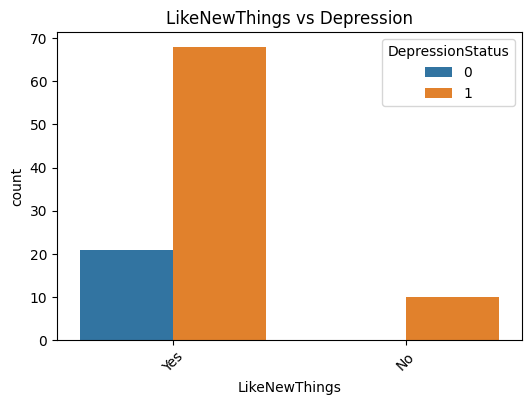

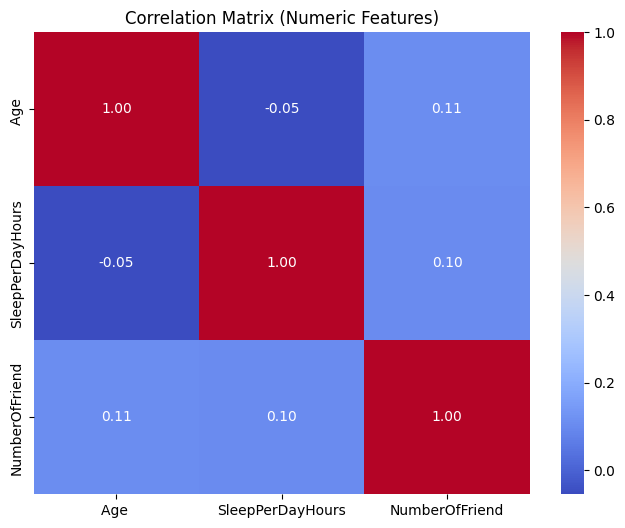

In [17]:
#EDA

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Depression Status Distribution")
plt.xlabel("Depression (0=No, 1=At Risk)")
plt.ylabel("Count")
plt.show()

print(y.value_counts(normalize=True))

numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

X[numeric_cols].hist(figsize=(12,8), bins=15)
plt.suptitle("Distribution of Numeric Features")
plt.show()

for col in numeric_cols:
    plt.figure(figsize=(5,4))
    sns.boxplot(x=y, y=X[col])
    plt.title(f"{col} vs Depression")
    plt.show()

categorical_cols = X.select_dtypes(include=["object", "category", "string"]).columns

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue=y, data=data)
    plt.title(f"{col} vs Depression")
    plt.xticks(rotation=45)
    plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(X[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (Numeric Features)")
plt.show()



EDA Summary and Next-Step Decisions
1) Data situation (what the dataset looks like)
* Size: 99 student records with 9 original features (mixed numeric + categorical). After one-hot encoding, features expanded to 13 columns.
* Data types:
    * Numeric: Age, SleepPerDayHours, NumberOfFriend
    * Categorical: Gender, AcademicPerformance, TakingNoteInClass, FaceChallangesToCompleteAcademicTask, LikePresentation, LikeNewThings
* Missing data: Only NumberOfFriend had 4 missing values; it was imputed using the median (missing values became 0).
2) Target variable (DepressionStatus) and class balance
* Original target had 3 levels: Sometimes (44), Yes (34), No (21).
* For modeling, it was converted into binary:
    * At Risk (1): Yes + Sometimes → 78 (78.8%)
    * Not Depressed (0): No → 21 (21.2%)
* Implication: The target is imbalanced, so accuracy alone is not reliable. We should emphasize F1-score, Recall, and ROC-AUC.
3) What we learned from distributions and relationships
* SleepPerDayHours vs Depression: The boxplot shows a noticeable difference between groups; sleep appears to be a potentially meaningful predictor.
* NumberOfFriend: The histogram and boxplot show a highly skewed distribution with large outliers (values up to ~100). This feature may influence models and should be handled carefully.
* Age: Only small differences between groups; likely a weaker predictor.
* Categorical vs Depression: Some categories show visible differences (e.g., challenges completing tasks and academic performance patterns), but several features are not strongly separated visually.
* Correlation (numeric): Correlations are close to zero (no strong multicollinearity), so numeric variables are not redundant.
4) Decision process for next steps (modeling plan)
1. Address class imbalance
    * Use Stratified splitting and Stratified K-Fold Cross-Validation.
    * Use class_weight="balanced" (at least for Logistic Regression and Random Forest).
2. Use leakage-safe preprocessing
    * Put imputation + scaling + encoding inside a Pipeline (not manual preprocessing before splitting).
3. Start with a baseline, then compare
    * Baseline: Logistic Regression (interpretable).
    * Compare with: Random Forest (handles nonlinearity and outliers better).
    * Optional: XGBoost only with careful tuning due to small sample size.
4. Evaluate with robust metrics
    * Report F1, Recall, and ROC-AUC (not accuracy only), plus confusion matrix.
5. Interpretability
    * Use Logistic Regression coefficients and/or permutation importance to identify key predictors.
Conclusion: The dataset is small but clean and usable. The main challenges are class imbalance and skew/outliers in NumberOfFriend. The next step is to implement a Pipeline + Stratified 5-fold CV and compare baseline vs ensemble models using F1/Recall/ROC-AUC.

In [18]:
#prepocessing data pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Detect columns from ORIGINAL X
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object", "category", "string"]).columns

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

# Numeric pipeline → Impute missing values + Scale
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline → Impute + OneHotEncode
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# 2️⃣ Combine with ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, numeric_cols),
        ("cat", categorical_pipeline, categorical_cols)
    ]
)

# 3️⃣ Train-Test Split
# ==============================

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

Numeric: Index(['Age ', 'SleepPerDayHours', 'NumberOfFriend'], dtype='str')
Categorical: Index(['Gender', 'AcademicPerformance', 'TakingNoteInClass',
       'FaceChallangesToCompleteAcademicTask', 'LikePresentation',
       'LikeNewThings'],
      dtype='str')


In [19]:
#  Baseline pipeline (simple, interpretable)
from sklearn.linear_model import LogisticRegression

baseline_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("model", LogisticRegression(max_iter=5000, random_state=42))
])


# Train Model

baseline_pipeline.fit(X_train, y_train)

# 6️⃣ Evaluate Baseline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = baseline_pipeline.predict(X_test)

print("Baseline Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Baseline Logistic Regression Results
Accuracy: 0.9

Confusion Matrix:
 [[ 3  1]
 [ 1 15]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.94      0.94      0.94        16

    accuracy                           0.90        20
   macro avg       0.84      0.84      0.84        20
weighted avg       0.90      0.90      0.90        20



=== Baseline: Logistic Regression ===
Accuracy: 0.9

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.94      0.94      0.94        16

    accuracy                           0.90        20
   macro avg       0.84      0.84      0.84        20
weighted avg       0.90      0.90      0.90        20



<Figure size 700x600 with 0 Axes>

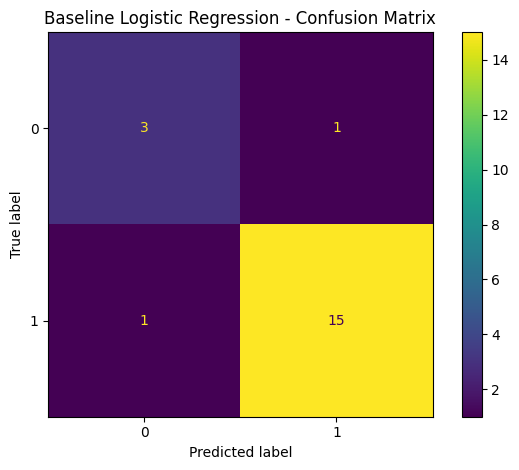

<Figure size 700x600 with 0 Axes>

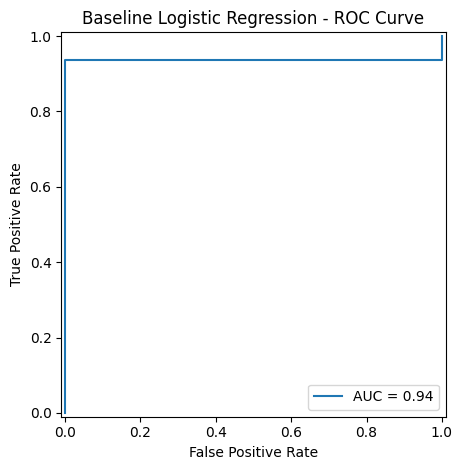

<Figure size 700x600 with 0 Axes>

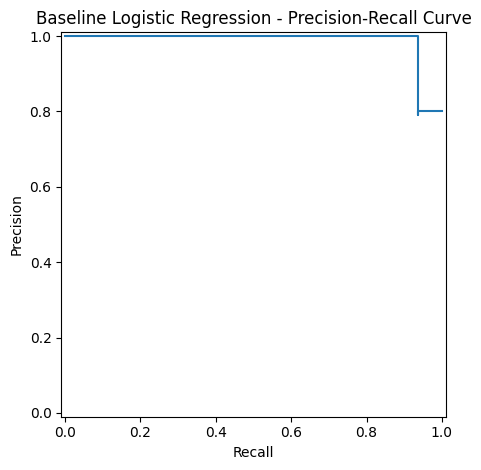

In [20]:
# ==============================
# Baseline model evaluation + plots (Matplotlib only)
# Works for binary or multi-class targets
# Assumes you already have:
# baseline_pipeline, X_test, y_test
# ==============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    roc_curve,
    auc,
    RocCurveDisplay,
    precision_recall_curve,
    PrecisionRecallDisplay
)

# ---- 1) Predictions
y_pred = baseline_pipeline.predict(X_test)

print("=== Baseline: Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---- 2) Confusion Matrix Plot (works for binary + multiclass)
plt.figure(figsize=(7, 6))
ConfusionMatrixDisplay.from_estimator(
    baseline_pipeline,
    X_test,
    y_test,
    values_format="d",   # use "d" for counts; change to ".2f" if you want normalized
)
plt.title("Baseline Logistic Regression - Confusion Matrix")
plt.tight_layout()
plt.show()

# ---- 3) ROC + Precision-Recall (ONLY for binary classification)
# If your target has more than 2 classes, we skip ROC/PR here (can add One-vs-Rest later)
classes = np.unique(y_test)

if len(classes) == 2 and hasattr(baseline_pipeline, "predict_proba"):
    # Probability of the positive class
    y_prob = baseline_pipeline.predict_proba(X_test)[:, 1]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 6))
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    plt.title("Baseline Logistic Regression - ROC Curve")
    plt.tight_layout()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)

    plt.figure(figsize=(7, 6))
    PrecisionRecallDisplay(precision=precision, recall=recall).plot()
    plt.title("Baseline Logistic Regression - Precision-Recall Curve")
    plt.tight_layout()
    plt.show()

else:
    print("\n[Info] ROC/PR plots are shown only for binary classification.")
    print("       Your target appears to have", len(classes), "classes:", classes)
    print("       If you want, I can add multiclass ROC (One-vs-Rest) plots next.")
